# Examples: Recommender systems: Collaborative filtering
© ExploreAI Academy

## Collaborative-based Filtering

### How it works

<br></br>

<div align="center" style="width: 700px; font-size: 80%; text-align: center; margin-left: 80px">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/Utility_Matrix.jpg"
     alt="Collaborative-based Filtering - Utility Matrix"
     style="float: center; padding-bottom=0.5em"
     width=700px/>
Utility matrix used to assess the similarity between users who have rated items.
</div>

In content-based filtering, we looked at the similarity between the properties or attributes of items. In collaborative-based filtering, **we measure the similarity between users to make recommendations**.

To see how this works, consider several individuals who are currently using our collaborative-based recommender system. Simon, Kwanda, Kieran and Joanne have all rated certain books that they've read, and we've been able to capture these results. Using this information, we can construct what is known as a **Utility Matrix**, which (as shown in the figure above) is a structure simply capturing our rating data in a formal way. In the utility matrix, each user is represented as a row$^*$, and the items (books) in our catalogue make up features for each user - whether they have rated a book or not, and what ratings they have given. We note here importantly that this matrix is inherently *sparse*, as there are far more items available in the catalogue than a user's supplied ratings.  


Using this principle of user similarity, when we seek to make a recommendation for a user based on collaborative filtering, we usually seek to determine the *k-neighbors* who are most similar to the user. From these users, we then extract their highly-rated items and use these as a basis for recommendations.


In [1]:
# Import our regular old heroes
import numpy as np
import pandas as pd
import scipy as sp # <-- The sister of Numpy, used in our code for numerical efficiency.
import matplotlib.pyplot as plt
import seaborn as sns

# Entity featurization and similarity computation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Libraries used during sorting procedures.
import operator # <-- Convenient item retrieval during iteration
import heapq # <-- Efficient sorting of large lists

# Imported for our sanity
import warnings
warnings.filterwarnings('ignore')

In [3]:
anime_ratings = pd.read_csv('anime_cleaned.csv')
anime_ratings.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24.0,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.16,151266


In [ ]:
print (f'Number of ratings in dataset: {anime_ratings.shape[0]}')

Number of ratings in dataset: 12294


In [4]:
train_ratings = pd.read_csv('train_cleaned.csv')
train_ratings.head()

,user_id,anime_id,rating
0,1,11617.0,10.0
1,1,11757.0,10.0
2,1,15451.0,10.0
3,2,11771.0,10.0
4,3,20.0,8.0


In [5]:
# Merge the datasets on 'anime_id'
merged_df = pd.merge(train_ratings, anime_ratings, on='anime_id', how='inner')





In [6]:
# Display the first few rows of the merged dataframe
print("\nMerged DataFrame Preview:")
merged_df.head()


Merged DataFrame Preview:


,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members
0,1,11617.0,10.0,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",TV,12.0,7.7,398660
1,5,11617.0,2.0,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",TV,12.0,7.7,398660
2,7,11617.0,6.0,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",TV,12.0,7.7,398660
3,17,11617.0,8.0,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",TV,12.0,7.7,398660
4,27,11617.0,9.0,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",TV,12.0,7.7,398660


In [7]:
# Optionally, save the merged DataFrame to a new CSV file
merged_df.to_csv('merged_anime_train.csv', index=False)

### Implementation

We now implement a simple collaborative filtering-based recommendation algorithm.

In a similar process to content filtering, where we first had to gather item features before we could compute their similarity, within collaborative filtering, we initially needed to gather all user ratings together by forming a utility matrix.

Using `pandas`, we can construct our utility matrix easily by using the `pivot_table` function:

In [7]:
util_matrix = merged_df.pivot_table(index=['user_id'],
                                       columns=['name'],
                                       values='rating_x')
util_matrix.shape

(10387, 7907)

We previously mentioned that the utility matrix is sparse, as it is unlikely that a user has read many of the books within the entire Goodbooks library. To illustrate this point, let's visualise a portion of the utility matrix:

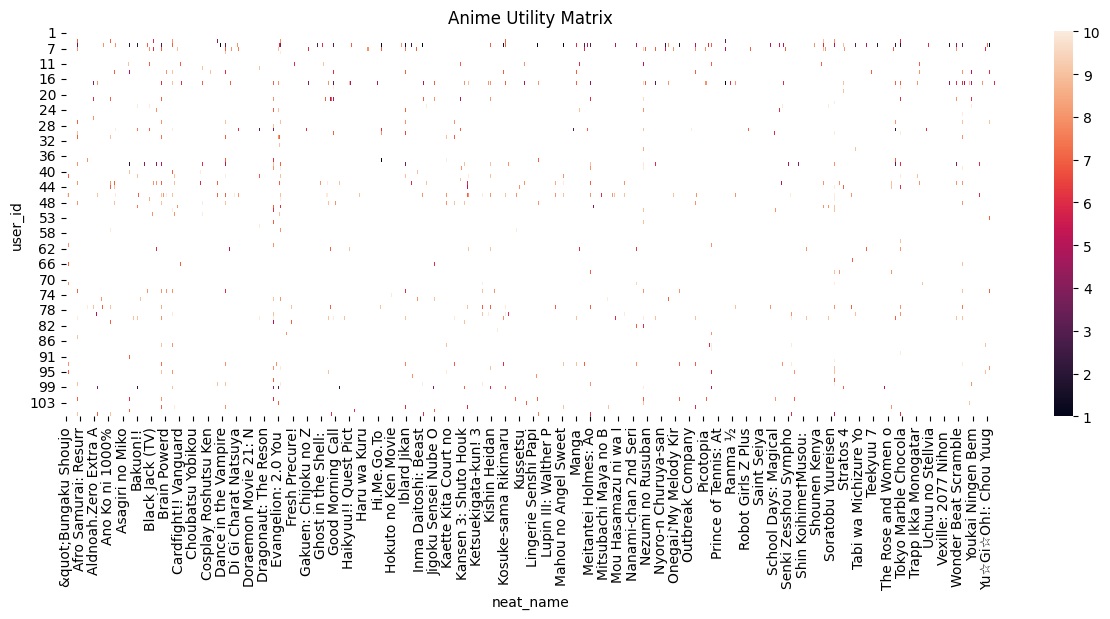

In [8]:
# Create a neat version of the utility matrix to assist with plotting book titles
merged_df['neat_name'] = merged_df['name'].apply(lambda x: x[:20])
util_matrix_neat = merged_df.pivot_table(index=['user_id'],
                                            columns=['neat_name'],
                                            values='rating_x')

fig, ax = plt.subplots(figsize=(15,5))
# We select only the first 100 users for ease of computation and visualisation.
# You can play around with this value to see more of the utility matrix.
_ = sns.heatmap(util_matrix_neat[:100], annot=False, ax=ax).set_title('Anime Utility Matrix')

Note that the white regions of the heatmap indicate cells in the utility matrix for which we have no rating data.

With our utility matrix created, we now preprocess our data in preparation for similarity computation. This is done by normalising each user's set of ratings, filling in Nan values with 0, [transposing](https://www.khanacademy.org/math/linear-algebra/matrix-transformations/matrix-transpose/v/linear-algebra-transpose-of-a-matrix) our matrix for easier indexing, dropping users with no ratings, and storing the matrix in a sparse representation to save memory.   

In [9]:
from scipy.sparse import csr_matrix

# Normalize each row (a given user's ratings) of the utility matrix
util_matrix_norm = util_matrix.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)), axis=1)
# Fill Nan values with 0's, transpose matrix, and drop users with no ratings
util_matrix_norm.fillna(0, inplace=True)
util_matrix_norm = util_matrix_norm.T
util_matrix_norm = util_matrix_norm.loc[:, (util_matrix_norm != 0).any(axis=0)]
# Save the utility matrix in scipy's sparse matrix format
util_matrix_sparse = csr_matrix(util_matrix_norm.values)

We can now compute the similarity between users based on the ratings they have given various books

In [10]:
# Compute the similarity matrix using the cosine similarity metric
user_similarity = cosine_similarity(util_matrix_sparse.T)
# Save the matrix as a dataframe to allow for easier indexing
user_sim_df = pd.DataFrame(user_similarity,
                           index = util_matrix_norm.columns,
                           columns = util_matrix_norm.columns)

# Review a small portion of the constructed similarity matrix
user_sim_df[:5]

user_id,3,5,7,8,10,11,12,14,16,17,...,10964,10965,10966,10967,10968,10969,10970,10971,10972,10973
user_id,,,,,,,,,,,,,,,,,,,,,
3,1.000000,0.054259,0.162695,0.026066,-0.027226,0.049089,0.118871,-0.012660,0.050535,0.168410,...,0.000000,0.000333,0.088014,0.000000,-0.003930,-0.054731,0.018618,0.000000,0.000000,0.011405
5,0.054259,1.000000,0.085513,0.020188,0.028336,0.028753,0.048612,0.128188,0.000000,0.127079,...,0.015317,0.086241,0.031201,-0.014673,-0.001495,-0.002453,0.003055,0.000000,0.028839,-0.021490
7,0.162695,0.085513,1.000000,-0.011946,0.017756,-0.022596,0.041883,0.076354,0.021018,0.118253,...,0.000000,0.066167,0.045798,0.073348,-0.000892,-0.015074,0.082636,0.041693,0.000000,0.034564
8,0.026066,0.020188,-0.011946,1.000000,-0.058026,0.000000,0.001633,-0.040281,0.000000,0.005022,...,0.000000,0.001120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10,-0.027226,0.028336,0.017756,-0.058026,1.000000,0.020449,0.004689,0.045926,0.000000,-0.015299,...,0.000000,0.053249,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


With our similarity matrix formed, we are once again in a position to make some recommendations.

As was the process for content-based filtering, we'll first look at generating top-N recommendations and then rating predictions using collaborative filtering.

#### Top-N Recommendations

In order to produce a list of top-N recommendations for collaborative filtering, the following simple algorithm can be followed:

  1. Select an initial reference user to generate recommendations for.
  2. Extract all the similarity values between the reference user and each other user in the similarity matrix.
  3. Sort the resulting similarity values in descending order, and select the $k$ most similar users based on these values.  
  5. For each selected user, collect their top-rated items.
  6. Form a tally of which items are most popular across the $k$ similar users. Do this by counting how many times a top-rated item is common amongst the other users.
  7. Sort the top-rated items according to the popularity tally. Return the top-N values as the result.
    
  
We implement this algorithmic process in the function below:

In [11]:
def collab_generate_top_N_recommendations(user, N=10, k=20):
    # Cold-start problem - no ratings given by the reference user.
    # With no further user data, we solve this by simply recommending
    # the top-N most popular books in the item catalogue.
    if user not in user_sim_df.columns:
        return merged_df.groupby('name').mean().sort_values(by='rating_x',
                                        ascending=False).index[:N].to_list()

    # Gather the k users which are most similar to the reference user
    sim_users = user_sim_df.sort_values(by=user, ascending=False).index[1:k+1]
    favorite_user_items = [] # <-- List of highest rated items gathered from the k users
    most_common_favorites = {} # <-- Dictionary of highest rated items in common for the k users

    for i in sim_users:
        # Maximum rating given by the current user to an item
        max_score = util_matrix_norm.loc[:, i].max()
        # Save the names of items maximally rated by the current user
        favorite_user_items.append(util_matrix_norm[util_matrix_norm.loc[:, i]==max_score].index.tolist())

    # Loop over each user's favourite items and tally which ones are
    # most popular overall.
    for item_collection in range(len(favorite_user_items)):
        for item in favorite_user_items[item_collection]:
            if item in most_common_favorites:
                most_common_favorites[item] += 1
            else:
                most_common_favorites[item] = 1
    # Sort the overall most popular items and return the top-N instances
    sorted_list = sorted(most_common_favorites.items(), key=operator.itemgetter(1), reverse=True)[:N]
    top_N = [x[0] for x in sorted_list]
    return top_N

With our algorithm defined, let's go and look at the recommended books for our friend, user 314:

In [12]:
# Our recommended list for user 314
collab_generate_top_N_recommendations(314)

['Elfen Lied',
 'No Game No Life',
 'Shingeki no Kyojin',
 'Black Lagoon',
 'Cowboy Bebop',
 'Zetsuen no Tempest',
 'Great Teacher Onizuka',
 'Steins;Gate',
 'Angel Beats!',
 'Mononoke Hime']

In [13]:
# User 314's historical ratings
merged_df[merged_df['user_id'] == 314][:][['name','rating_x']].sort_values(by='rating_x', ascending=False)[:10]

,name,rating_x
608693,Black Lagoon Omake,10.0
48833,Zetsuen no Tempest,10.0
246822,Gangsta.,10.0
415120,Black Lagoon,10.0
71162,Dungeon ni Deai wo Motomeru no wa Machigatteir...,9.0
74227,Rokka no Yuusha,9.0
544942,Sukitte Ii na yo.,9.0
216734,Kyoukai no Kanata,9.0
249448,Yamada-kun to 7-nin no Majo (TV),9.0
452756,Ao Haru Ride,9.0


In [14]:
# Our recommended list for user 200
collab_generate_top_N_recommendations(200)

['Shingeki no Kyojin',
 'Death Note',
 'Sword Art Online',
 'Fairy Tail',
 'Fullmetal Alchemist: Brotherhood',
 'Dragon Ball GT',
 'Dragon Ball Z',
 'Fullmetal Alchemist',
 'Naruto',
 'Code Geass: Hangyaku no Lelouch']

In [15]:
# User 200's historical ratings
merged_df[merged_df['user_id'] == 200][:][['name','rating_x']].sort_values(by='rating_x', ascending=False)[:10]

,name,rating_x
10532,Sen to Chihiro no Kamikakushi,10.0
345931,Mononoke Hime,10.0
691637,Berserk: Ougon Jidai-hen II - Doldrey Kouryaku,10.0
685566,Juubee Ninpuuchou,10.0
654046,Gungrave,10.0
604090,Gankutsuou,10.0
515741,Gedo Senki,10.0
468203,Cowboy Bebop: Tengoku no Tobira,10.0
435642,Redline,10.0
421111,Baccano!,10.0


#### Rating Prediction

We can generate user-item ratings for collaborative filtering using the following algorithmic steps:

   1. Select a reference user from the database and a reference item (book) they have _not_ rated.
   2. For the reference user, gather the similarity values between them and each other user.
   3. Sort the gathered similarity values in descending order.
   4. Select the $k$ highest similarity values which are above a given threshold value, creating a collection $K$ similar users.
   5. For each user in collection $K$, get their rating of the reference item if it exists (other users may not have rated this item as well)
   6. Compute a weighted average rating from both the gathered rating values and user similarity values. This is expressed in the formula as:
   
   $$ \hat{R}_{ju} = \frac{\sum_{n \in K} s_{nu} \times r_{nj}}{\sum_{n \in K} s_{nu}}   $$
   
   Where $\hat{R}_{ju}$ is the weighted average computed for the reference item $j$ and reference user $u$, $K$ is the collection of similar users, $s_{nu}$ is the similarity computed between users $n$ and $u$, and $r_{nj}$ is the known rating user $n$ has given item $j$.
   7. We return the weighted average $\hat{R}_{ju}$ as the prediction for our reference item.
   
   
We implement this algorithmic process in the function below:

In [16]:
def collab_generate_rating_estimate(anime_name, user, k=20, threshold=0.0):
    # Gather the k users which are most similar to the reference user
    sim_users = user_sim_df.sort_values(by=user, ascending=False).index[1:k+1]
    # Store the corresponding user's similarity values
    user_values = user_sim_df.sort_values(by=user, ascending=False).loc[:,user].tolist()[1:k+1]
    rating_list = [] # <-- List of k user's ratings for the reference item
    weight_list = [] # <-- List of k user's similarities to the reference user

    # Create a weighted sum for each of the k users who have rated the
    # reference item (anime).
    for sim_idx, user_id in enumerate(sim_users):
        # User's rating of the item
        rating = util_matrix.loc[user_id, name]
        # User's similarity to the reference user
        similarity = user_values[sim_idx]
        # Skip the user if they have not rated the item, or are too dissimilar to
        # the reference user
        if (np.isnan(rating)) or (similarity < threshold):
            continue
        elif not np.isnan(rating):
            rating_list.append(rating*similarity)
            weight_list.append(similarity)
    try:
        # Return the weighted sum as the predicted rating for the reference item
        predicted_rating = sum(rating_list)/sum(weight_list)
    except ZeroDivisionError:
        # If no ratings for the reference item can be collected, return the average
        # rating given by all users for the item.
        predicted_rating = np.mean(util_matrix[name])
    return predicted_rating

Once again we can use our newly formed function to generate rating predictions for user 200.

We start with some known ratings:

In [17]:
name = "Shingeki no Kyojin"
actual_rating = merged_df[(merged_df['user_id'] == 200) & (merged_df['name'] == name)]['rating_x'].values[0]
pred_rating = collab_generate_rating_estimate(anime_name = name, user = 200)
print (f"Anime name - {name}")
print ("---")
print (f"Actual rating: \t\t {actual_rating}")
print (f"Predicted rating: \t {pred_rating}")

Anime name - Shingeki no Kyojin
---
Actual rating: 		 10.0
Predicted rating: 	 9.205585250019434


In [18]:
name = "Fullmetal Alchemist"
actual_rating = merged_df[(merged_df['user_id'] == 200) & (merged_df['name'] == name)]['rating_x'].values[0]
pred_rating = collab_generate_rating_estimate(anime_name = name, user = 200)
print (f"Anime name - {name}")
print ("---")
print (f"Actual rating: \t\t {actual_rating}")
print (f"Predicted rating: \t {pred_rating}")

Anime name - Fullmetal Alchemist
---
Actual rating: 		 10.0
Predicted rating: 	 8.91056901668695


In [27]:
# Load the test data
test_data = pd.read_csv('test_cleaned.csv')  # Adjust the file path as needed
test_data.shape

(633686, 2)

In [30]:
def user_based_predict(user_id, anime_id, k=20, threshold=0.0):
    if user_id not in user_sim_df.index or anime_id not in util_matrix.columns:
        return np.nan  # Return NaN if user or anime ID is not in the dataset

    # Get similar users' ratings
    similar_users = user_sim_df.sort_values(by=user_id, ascending=False).index[1:k+1]
    similar_users_ratings = util_matrix.loc[similar_users, anime_id]
    similar_users_similarities = user_sim_df.loc[similar_users, user_id]

    rating_list = []
    weight_list = []

    for sim_user, similarity in zip(similar_users, similar_users_similarities):
        rating = util_matrix.loc[sim_user, anime_id]
        if not np.isnan(rating) and similarity >= threshold:
            rating_list.append(rating * similarity)
            weight_list.append(similarity)

    if weight_list:
        predicted_rating = sum(rating_list) / sum(weight_list)
    else:
        predicted_rating = np.nan  # or use the average rating for the item

    return predicted_rating

def generate_user_based_submission(test_data, k=20, threshold=0.0):
    predictions = []
    for row in test_data.itertuples(index=False):
        user_id, anime_id = row.user_id, row.anime_id
        pred = user_based_predict(user_id, anime_id, k=k, threshold=threshold)
        predictions.append((f"{user_id}_{anime_id}", pred))

    submission = pd.DataFrame(predictions, columns=['ID', 'rating'])
    assert len(submission) == len(test_data), f"Submission must have {len(test_data)} rows, but has {len(submission)} rows."

    return submission

# Generate predictions for the test data
submission = generate_user_based_submission(test_data)


In [31]:
submission.head()

,ID,rating
0,40763_21405,NaN
1,68791_10504,NaN
2,40487_1281,NaN
3,55290_165,NaN
4,72323_11111,NaN


In [32]:
submission.shape

(633686, 2)

In [ ]:
# Save the submission to a CSV file
submission.to_csv('submission.csv', index=False)
print("Submission file created successfully.")

___
### Metric comparison: Student exercise
Within the above sections, we implemented functions to anime ratings using both collaborative and content filtering. Using an appropriate performance metric such as RMSE or MAE, determine which of these two methods is more appropriate for the anime dataset. You could do this by:
* Divide the anime dataframe into a train and test subset using random sampling. Ensure that the train set is 90 - 95% of the total data.
* Computing similarity matrices using the data available in the train set (this will mainly affect collaborative filtering)
* For each user-item rating in the test set, generate a rating prediction.
* Use the historical rating data in the test set to quantify the performance of each technique.

Once you've computed these results, consider how you could improve either method to be more competitive. How feasible are these changes?
___

**Step 1: Split the Data**

In [26]:
from sklearn.model_selection import train_test_split
import numpy as np

# Split the data into train and test sets
train_df, test_df = train_test_split(merged_df, test_size=0.10, random_state=42)

# Verify the split
print(f"Training set size: {train_df.shape}")
print(f"Testing set size: {test_df.shape}")


Training set size: (290737, 10)
Testing set size: (32305, 10)


**Step 2: Compute Similarity Matrices (for Collaborative Filtering)**

Assuming the similarity matrices user_sim_df and util_matrix are constructed from the training set:

In [27]:
# Compute the user similarity matrix using the training data
# Example: using cosine similarity (you can use other methods as well)
from sklearn.metrics.pairwise import cosine_similarity

# Create the utility matrix from the training data
util_matrix_train = train_df.pivot_table(index='user_id', columns='name', values='rating_x')

# Compute the cosine similarity matrix for users
user_sim_df_train = pd.DataFrame(cosine_similarity(util_matrix_train.fillna(0)),
                                 index=util_matrix_train.index,
                                 columns=util_matrix_train.index)


**Step 3: Generate Rating Predictions**

Collaborative Filtering Predictions

In [31]:
def collab_generate_rating_estimate(anime_name, user, k=20, threshold=0.0):
    # Check if the anime exists in the utility matrix
    if anime_name not in util_matrix_train.columns:
        return np.nan  # Or some default value like the average rating of the user

    # Check if the user exists in the similarity matrix
    if user not in user_sim_df_train.index:
        return np.nan  # Or some default value

    # Gather the k users which are most similar to the reference user
    sim_users = user_sim_df_train.sort_values(by=user, ascending=False).index[1:k+1]
    user_values = user_sim_df_train.loc[sim_users, user].tolist()

    rating_list = []
    weight_list = []

    # Create a weighted sum for each of the k users who have rated the reference item
    for sim_idx, user_id in enumerate(sim_users):
        if anime_name in util_matrix_train.columns:
            rating = util_matrix_train.loc[user_id, anime_name]
            similarity = user_values[sim_idx]
            if (np.isnan(rating)) or (similarity < threshold):
                continue
            elif not np.isnan(rating):
                rating_list.append(rating * similarity)
                weight_list.append(similarity)

    try:
        predicted_rating = sum(rating_list) / sum(weight_list)
    except ZeroDivisionError:
        predicted_rating = np.mean(util_matrix_train[anime_name]) if not np.isnan(util_matrix_train[anime_name].mean()) else 0.0
    return predicted_rating

# Predict ratings for the test set using collaborative filtering
test_df['collab_pred'] = test_df.apply(lambda row: collab_generate_rating_estimate(row['name'], row['user_id']), axis=1)


In [ ]:
# Predict ratings for the test set using collaborative filtering
test_df['collab_pred'] = test_df.apply(lambda row: collab_generate_rating_estimate(row['name'], row['user_id']), axis=1)


**Content-Based Filtering Predictions**

For content-based filtering, you need to have some content features to compute similarities. Assuming you have features such as genre, type, etc.

python


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TF-IDF matrix for anime genres
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(train_df['genre'])

# Compute the cosine similarity matrix for anime items
anime_sim_df = pd.DataFrame(cosine_similarity(tfidf_matrix), index=train_df['name'], columns=train_df['name'])

def content_generate_rating_estimate(anime_name, user, k=20, threshold=0.0):
    sim_animes = anime_sim_df.sort_values(by=anime_name, ascending=False).index[1:k+1]
    anime_values = anime_sim_df.sort_values(by=anime_name, ascending=False).loc[:,anime_name].tolist()[1:k+1]
    rating_list = []
    weight_list = []

    user_ratings = util_matrix_train.loc[user]
    for sim_idx, anime in enumerate(sim_animes):
        rating = user_ratings[anime]
        similarity = anime_values[sim_idx]
        if (np.isnan(rating)) or (similarity < threshold):
            continue
        elif not np.isnan(rating):
            rating_list.append(rating*similarity)
            weight_list.append(similarity)
    try:
        predicted_rating = sum(rating_list)/sum(weight_list)
    except ZeroDivisionError:
        predicted_rating = np.mean(user_ratings)
    return predicted_rating

# Predict ratings for the test set using content-based filtering
test_df['content_pred'] = test_df.apply(lambda row: content_generate_rating_estimate(row['name'], row['user_id']), axis=1)


 **Calculate RMSE or MAE**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE and MAE for collaborative filtering
rmse_collab = np.sqrt(mean_squared_error(test_df['rating_x'], test_df['collab_pred']))
mae_collab = mean_absolute_error(test_df['rating_x'], test_df['collab_pred'])

# Calculate RMSE and MAE for content-based filtering
rmse_content = np.sqrt(mean_squared_error(test_df['rating_x'], test_df['content_pred']))
mae_content = mean_absolute_error(test_df['rating_x'], test_df['content_pred'])

print(f"Collaborative Filtering - RMSE: {rmse_collab}, MAE: {mae_collab}")
print(f"Content-Based Filtering - RMSE: {rmse_content}, MAE: {mae_content}")



### Other considerations

Here are a couple more things to take into account when implementing these methods:

 - **Diversity of suggestions**: As has already been observed within this train, the diversity of recommendations offered by a recommender algorithm are important. In this sense, collaborative filtering is often considered to produce superior results over content-based filtering.  


 - **Computational requirements**: While we've used simple examples to illustrate the implementation of collaborative and content-based filtering, you should not overlook considerations for the type of computational resources these methods rely upon. In this sense, both methods require the computation of similarity structures when making recommendations. For content-based filtering, this similarity structure tends to be smaller compared to its collaborative counterpart, as large recommendation services tend to have far more users than items in their databases. The storage of these similarity matrices can take up considerable space. Furthermore, the properties of items remain quite static, meaning that once the item similarity matrix is computed, it can be reused indefinitely (until more properties are used for similarity computation). On the other hand, as user ratings are added to at a constant rate, the utility matrix and, subsequently, the user similarity matrix need to be updated regularly to ensure appropriate recommendations are produced.         
  
  
 - **Sparsity issues**: We've briefly mentioned the Cold-start problem before within this train. To reiterate the point, due to the sparse nature of the utility matrix, it can often become very difficult to make recommendations for users who have few or no ratings captured. However, as time increases, systems that make use of collaborative filtering techniques get progressively better as they passively acquire richer rating data.  


 - **Hybrid approaches**: In light of the points raised above, one may wonder if there is a 'best of both worlds' approach for recommendation systems which overcomes the limitations of each method. The short is that there is, and this consists of hybrid content-collaborative filtering systems. These are hot research topics at the moment, with all major tech companies such as Google, Netflix, Facebook, and Amazon refining such hybrid approaches.

## Conclusion

Phew! We've covered a lot of ground. Hopefully, at this point, the ideas behind recommender systems and why they are so economically and socially important are a bit less mystical to us. In this train, we explored the use of collaborative filtering within recommender systems and the theory behind this method. Lastly, we used the results obtained in our implementation step to discuss some trade-offs offered between content and collaborative filtering.

## Appendix
Links to additional resources to help with the understanding of concepts presented in the train:
- [Overview of Collaborative Filtering](https://youtu.be/h9gpufJFF-0)

#  

<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/ExploreAI_logos/EAI_Blue_Dark.png"  style="width:200px";/>
</div>